# Is this cat carrying a mouse?

This is where I try image processing tools on pictures of my cats. The pictures are taken by a raspberry pi
camera mounted above the cat flap. The goal is to identify whether a cat approaching the cat flap is carrying a mouse, so that the cat flap can close automatically. 

Below, I go over several options for processing images returned by the cat flap camera:

1.  Line and contour finding in OpenCV
2.  Background subtraction
3.  Haar cascades
4.  Applying tensorflow models for object detection
5.  Fine-tuning a pre-trained tensorflow model

In [1]:
import base64
import cv2
from datetime import datetime, date
from io import BytesIO
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps, ImageColor, ImageDraw, ImageFont
import os
import re

### Read and index images

I use [Motion](https://motion-project.github.io/) to detect movement and store pictures. Motion encodes the time the picture was taken and an "event id" into the filename. I also make motion take regular snapshots, and they are stored using similar filenames. The code below finds picture files in a directory, parses their filenames, and keeps them in a list.

In [2]:
def _eventkey(event):
    return event['timeofday'] + event['idx']


def catalog_files(directory):
    """Look for files matching the motion image or snapshot pattern.
    Returns a tuple of events and snapshots directories.
    Events are keyed by event id (a motion-specific grouping of events). events[event_id] is a list of
    events ordered by timestamp.
    Snapshots are keyed by a string representation of the day and hour they were taken. This is useful
    because it makes the snapshot key a prefix of the timestamp embedded in the image filenames. Also, this
    makes it so you can interpret the key as an integer and add one to get the key of the next snapshot,
    unless your current key is from 23:00 hours, in which case it will have been too dark to see anything
    anyway. This will be true until I figure out how to provide the IR LEDs I bought with an adequate
    power supply. If you already have IR lighting, or are living much farther north or south than I,
    you will have to solve this before me.
    """
    events = {}
    snapshots = {}
    img_pattern = re.compile('([\d]+)-([\d]+)-([\d]+).jpg')
    snapshot_pattern = re.compile('([\d])+-([\d]+)-snapshot.jpg')
    for f in os.listdir(directory):
        x = re.match(img_pattern, f)
        if x is not None:
            event = x.group(1)
            timeofday = x.group(2)
            exacttime = datetime.strptime(timeofday, '%Y%m%d%H%M%S')
            ev = {
                'id': event,
                'timeofday': timeofday,
                'day': exacttime.date(),
                'hms': (exacttime.hour, exacttime.minute, exacttime.second),
                'idx': x.group(3),
                'filename': directory + '/' + f
            }            
            if event not in events:
                events[event] = []
            events[event].append(ev)
        else:
            x = re.match(snapshot_pattern, f)
            if x is not None:
                event = x.group(1)
                timeofday = x.group(2)
                exacttime = datetime.strptime(timeofday, '%Y%m%d%H%M%S')
                snap = {
                    'id': event,
                    'timeofday': timeofday,
                    'day': exacttime.date(),
                    'hms': (exacttime.hour, exacttime.minute, exacttime.second),
                    'filename': directory + '/' + f
                }
                houroftheday = timeofday[0:10]
                snapshots[houroftheday] = snap
    for _, v in events.items():
        v.sort(key=_eventkey)
    return (events, snapshots)

def list_dates(events, snapshots):
    snapshot_days = set([x['day'] for x in snapshots.values()])
    event_days = set()
    ids_by_day = {}
    for i, ev in events.items():
        days = set([ x['day'] for x in ev])
        event_days |= days
        for d in days:
            if d in ids_by_day:
                ids_by_day[d].append(i)
            else:
                ids_by_day[d] = [i]
    ed = list(event_days)
    sd = list(snapshot_days)
    ed.sort()
    sd.sort()
    return (ed, sd, ids_by_day)
        
        
events, snapshots = catalog_files('./may13')
list_dates(events, snapshots)


([datetime.date(2020, 5, 13)],
 [datetime.date(2020, 5, 13)],
 {datetime.date(2020, 5, 13): ['04', '05', '06', '07', '08']})

In [3]:
def images_for_event(day, event_id, events, snapshots):
    """Returns a list of image files and a snapshot file for a given day and event id.
    There is an edge case when an event id has been re-used on a day (this can happen if motion
    is restarted); that edge case is not handled properly here, I just return the snapshot for the first event.
    """
    if event_id not in events:
        return {}
    imagefiles = {}
    for ev in events[event_id]:
        if ev['day'] == day:
            fname = ev['filename']
            pilimage = Image.open(fname)
            imagefiles[fname] = pilimage
    snapimage = None
    if snapshots is not None:
        snapkey = events[event_id][0]['timeofday'][0:10]
        if snapkey not in snapshots:
            later = int(snapkey) + 1
            if str(later) in snapshots:
                snapkey = str(later)
            else:
                earlier = int(snapkey) - 1
                if str(earlier) in snapshots:
                    snapkey = str(earlier)
        if snapkey in snapshots:
            snap = snapshots[snapkey]['filename']
            snapimage = Image.open(snap)
    return (imagefiles, snapimage)
        

### Thumbnail view of images


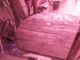


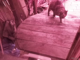
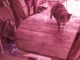
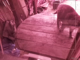
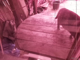
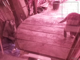
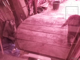
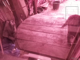
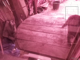
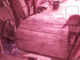
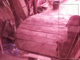
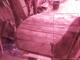
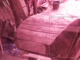
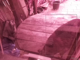
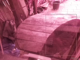
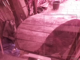
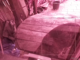
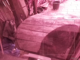
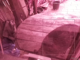
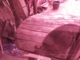
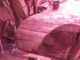
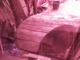
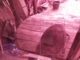
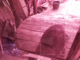
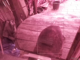
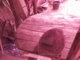
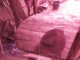
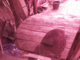
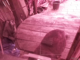
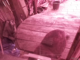
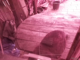
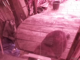
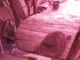
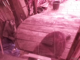
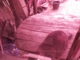
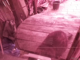
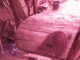
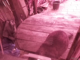
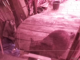
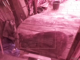
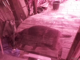
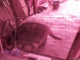
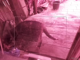
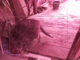
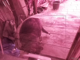
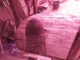
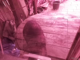
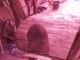
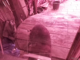
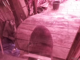
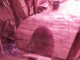
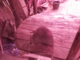
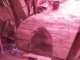
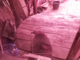
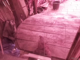
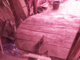
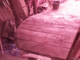
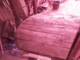
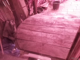
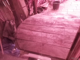
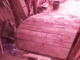
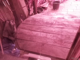
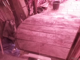
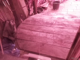
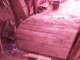
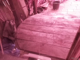
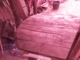
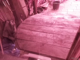
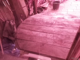
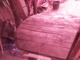
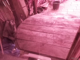
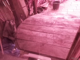
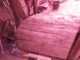
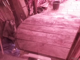
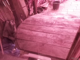
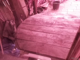

In [4]:
def _src_from_pil(img, imgsize=None):
    x = img
    if imgsize is not None:
        x = img.resize(imgsize)
    with BytesIO() as buffer:
        x.save(buffer, 'png')
        b64value = base64.b64encode(buffer.getvalue()).decode()
        return f'data:image/png;base64,{b64value}'

def gallery(images, imgsize=None):
    """Shows a set of images in a gallery view.
    
    Args:
    @images: iterable of (name, PIL.Image.Image) tuples or of (name, url) tuples.
    @imgsize: If set, images are resized to this. Pair of pixel counts.
    """
    figures = []
    for cpt, image in images.items():
        if isinstance(image, Image.Image):
            src = _src_from_pil(image, imgsize)
            caption = cpt
        else:
            src = image
            caption = f'<figcaption style="font-size: 0.6em">{image}</figcaption>'
        figures.append(f'''
            <figure style="margin: 5px;">
              <img src="{src}" alt="{caption}">
              {caption}
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

img, snap = images_for_event(day=date(2020, 5, 13), event_id='05', events=events, snapshots=snapshots)
snapline = gallery(images={'snapshot': snap}, imgsize=(80, 60))
imgline = gallery(images=img, imgsize=(80, 60))

display(snapline)
display(imgline)

### Take a closer look at one image

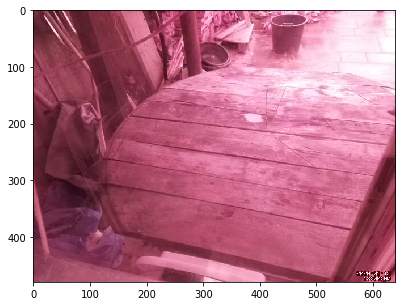

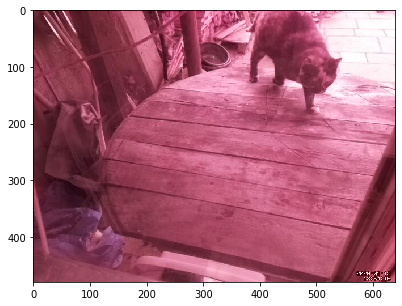

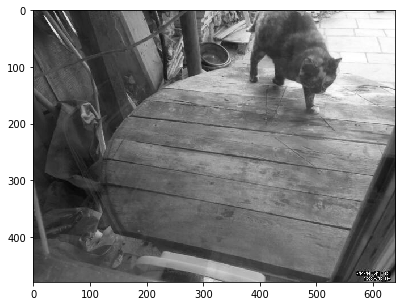

In [5]:
name = './may13/05-20200513135416-01.jpg'
cur = img[name]

# The images taken by the raspberry pi camera are red because it's an IR camera (so it works better in
# twilight, which is when cats like to hunt).
def display_image(image, cmap=None):
    fig = plt.figure(figsize=(7, 5))
    plt.grid(False)
    plt.imshow(image, cmap=cmap)
    
# I want to use OpenCV for some image processing tasks. However, I cannot use only OpenCV
# easily because I want to be able to show the images in this notebook, and some OpenCV
# versions (notably the one that you get if you install opencv in conda) do not let you
# use imshow() because they are not compiled with gtk support. The conda supporters say
# this is for portability reasons. I don't particularly want to use pipenv instead because
# it is a pain to get to work with Jupyter. For a version intended to be run in a docker
# vm (via binderhub for instance) I could install opencv globally instead of using
# a virtual environment. But in the meantime, here's some conversion routines.
    
# Pillow to OpenCV conversion and back. OpenCV uses BGR and pillow RGB.
# If you omit the colour conversion, you'll get bluish rather
# than reddish images in your display.
def pil2cv(image):
    return cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)

def cv2pil(image):
    if len(image.shape) < 3:
        # This is a grayscale image.
        return Image.fromarray(image).convert('L')
    return Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
cv_cur = pil2cv(cur)    
cv_gray = cv2.cvtColor(cv_cur, cv2.COLOR_BGR2GRAY)
snap_gray = cv2.cvtColor(pil2cv(snap), cv2.COLOR_BGR2GRAY)
    
display_image(snap)   
display_image(cur)
# matplotlib uses its own colour maps. For some reason, this makes it
# display grayscale images from opencv with a green tint. Looks very
# odd. Passing the colourmap explicitly avoids that.
display_image(cv_gray, cmap=plt.cm.gray)


### A bunch of terrifically useful opencv operations for preprocessing images

This is a toolbox for playing around with operations and parameters. No matter the eventual choice of tool or algorithm (haar cascades? machine learning?) it's generally useful to identify the area of interest in the picture (the cat, ideally the cat's face), maybe focus on it, maybe improve contrasts or remove noise.

Motion reports the area where it detected movement, so I can use that; however, motion occasionally reports an area that does not cover the whole cat. Contour detection (shown at the bottom of the next cell) is one option, though there are better ones.

hough found 11 lines
draw contour 0 of size 14767 in colour (255, 0, 0)
draw contour 1 of size 138160 in colour (0, 255, 0)
found 2 contours


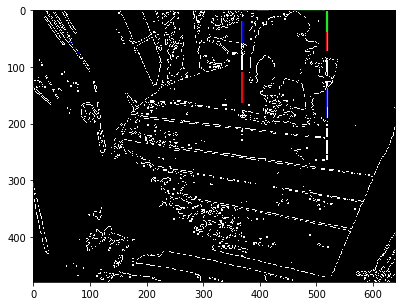

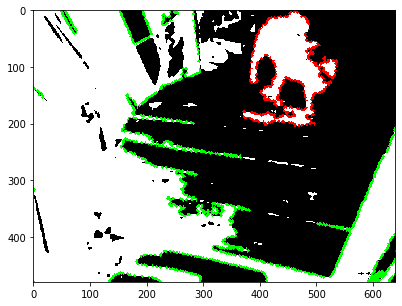

In [6]:
# Recommend running this on a grayscale image, probably also after running
# threshold or equalizeHist or both.
def canny(cv_img, thresh1=100, thresh2=200, aperture=3):
    return cv2.Canny(image=cv_img, threshold1=thresh1, threshold2=thresh2, apertureSize=aperture)

# This is amazingly good at helping you see the cat even in images taken in very dim light.
def equalizeHist(cv_img):
    return cv2.equalizeHist(cv_img)

# Should be applied to greyscale images.
# Possible values for mode are THRESH_BINARY, THRESH_BINARY_INV, THRESH_TRUNC, THRESH_TOZERO, THRESH_TOZERO_INV.
# you can add cv2.THRESH_OTSU to any of those.
def threshold(cv_img, thresh=127, max=255, mode=cv2.THRESH_BINARY):
    thresh, img = cv2.threshold(cv_img, thresh, max, mode)
    return img

# You can use ADAPTIVE_THRESH_GAUSSIAN_C as well.
def adaptiveThreshold(cv_img, max=255, mode=cv2.ADAPTIVE_THRESH_MEAN_C, neighbourhood=11, fudge=2):
    return cv2.adaptiveThreshold(cv_img, max, mode, cv2.THRESH_BINARY, neighbourhood, fudge)

# You can also try the non-probabilistic hough implementation, I just find this works ok for me.
# The default parameters are set to find very few lines.
def houghLinesP(cv_gray, distRes=1, angleRes=1, strength=40, minLL=25, maxLG=30):
    a = (angleRes * np.pi)/180
    cv_colour = cv2.cvtColor(cv_gray, cv2.COLOR_GRAY2RGB)
    colours = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    lines = cv2.HoughLinesP(cv_gray, distRes, a, strength, minLL, maxLG)
    print('hough found %d lines' % len(lines))
    counter = 0
    for points in lines:
        p = points[0]
        colour = colours[counter % len(colours)]
        cv2.line(cv_colour, (p[0],p[1]), (p[2],p[3]), colour, 1)
        counter += 1
    return cv_colour   

def blur(cv_img, mode=None, kernelSize=5):
    if mode is None:
        return cv2.blur(cv_img, (kernelSize, kernelSize))
    elif mode == 'Gaussian':
        return cv2.gaussianBlur(cv_img, (kernelSize, kernelSize), 0)
    elif mode == 'Median':
        return cv2.medianBlur(cv_img, kernelSize)
    
def cutout(cv_img, y1, y2, x1, x2):
    return cv_img[y1:y2, x1:x2]

def zoom(cv_img, factor=1.2):
    return cv2.resize(cv_img, None, fx=factor, fy=factor, interpolation=cv2.INTER_CUBIC)


# Contours work best on black-white images where the object you want to find is in white.
def contours(cv_img, min_area=10000):
    contours, hierarchy = cv2.findContours(cv_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cv_colour = cv2.cvtColor(cv_img, cv2.COLOR_GRAY2RGB)
    counter = 0
    colours = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    for c in contours:
        ar = cv2.contourArea(c)
        if ar >= min_area:
            colour = colours[counter % len(colours)]
            print('draw contour %d of size %d in colour %s' % (counter, ar, colour))
            counter += 1
            cv2.drawContours(cv_colour, c, -1, colour, 3)
    print('found %d contours' % counter)
    return cv_colour


# Because of parameter and preprocessing choices, this finds very few lines. This could be tweaked to find e.g. the
# edges of the windowframe or the cat flap. In earlier versions of the software, I made motion draw a box around
# the area where it detected movement and used houghlinesP to detect that box.
display_image(houghLinesP(canny(threshold(equalizeHist(cv_gray)))))

    
# display_image(equalizeHist(cv_gray), cmap=plt.cm.gray)
# display_image(threshold(equalizeHist(cv_gray), mode=cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU), cmap=plt.cm.gray)
display_image(contours(threshold(equalizeHist(blur(cv_gray)), mode=cv2.THRESH_BINARY_INV)))

### Background subtraction

I take hourly snapshots so that I know what the area in front of the cat flap looks like without a cat (of course it's possible that a cat happens to be sunbathing there at the time the snapshot is taken; I can either live with this or average the snapshots; see below for how).

draw contour 0 of size 10293 in colour (255, 0, 0)
found 1 contours


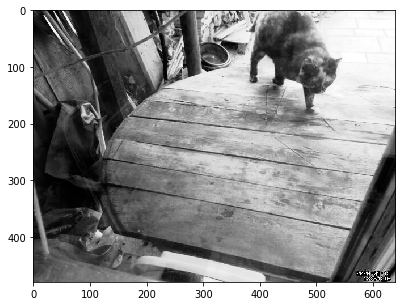

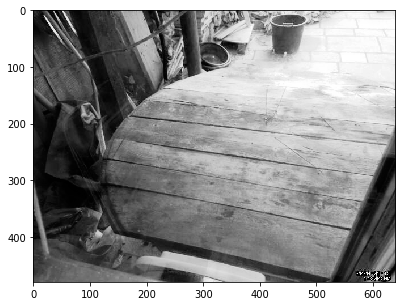

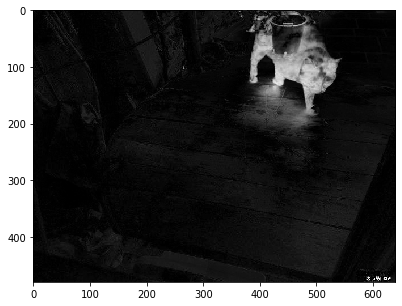

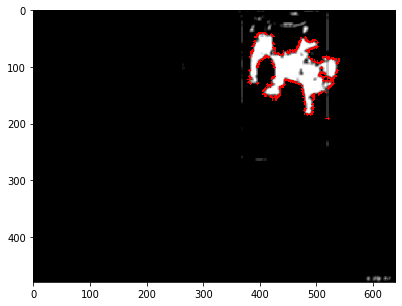

In [47]:
# For "naive" background subtraction, just take an image, find the closest (in time) snapshot for it, and subtract the
# images from each other. I don't think it makes sense to subtract colour pixels, so always operate on grayscale
# images. I also run equalizeHist in order to reduce differences in lighting.

cat1 = equalizeHist(cv_gray)
snap1 = equalizeHist(snap_gray)

display_image(cat1, cmap=plt.cm.gray)
display_image(snap1, cmap=plt.cm.gray)
diff = cv2.absdiff(snap1, cat1)

# You can see the bucket in the background 'through' the cat, which is an interesting side effect of the diff.
# Also, the cat's shadow shows up light on dark in the diff.
display_image(diff, cmap=plt.cm.gray)

# Different from the contours call shown previously: don't invert the threshold operation (the cat is already
# light on dark); don't equalizeHist (it'll amplify small differences in brightness between image and snapshot),
# and apply blur after threshold. This finds just one contour, and it's of the cat. Not good enough for
# figuring out whether the cat carries a mouse, but definitely good enough for identifying the area of interest.
display_image(contours(blur(threshold(diff))))


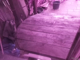
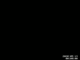
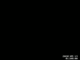
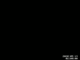
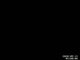
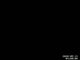
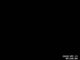
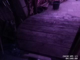
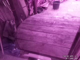
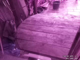
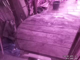
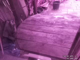
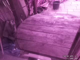
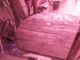
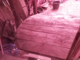

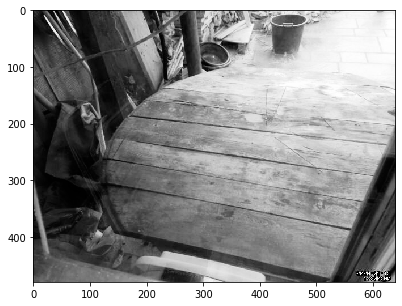

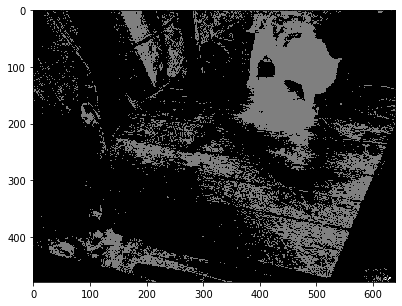

In [100]:
# OpenCV actually supports much more sophisticated background subtraction options.
backsub = cv2.createBackgroundSubtractorMOG2()
# Other algorithms are available, for example:
# backsub = cv2.createBackgroundSubtractorKNN()
# The C++ code has even more implementations, but only MOG2 and KNN are available in python afaict.
# MOG2 is based on Mahalanobis distance, KNN uses k-nearest-neighbours.

# You can call apply repeatedly. Roughly speaking, backsub maintains a 'running average' of all
# the images you have called 'apply' with. apply() returns the difference between the latest image
# you added and the background average.
# backsub.apply(equalizeHist(snap_gray))

allsnaps = {}
for snapkey, snapshot in snapshots.items():
    snapPil = Image.open(snapshot['filename'])
    allsnaps[snapkey] = snapPil
    
display(gallery(allsnaps, (80,60)))

backsubMay13MOG = cv2.createBackgroundSubtractorMOG2(history=20, varThreshold=16, detectShadows=True)

# Load all the snapshots for may 13:
for snapkey, snapshot in snapshots.items():
    s = snapshot['filename']
    snapImage = equalizeHist(cv2.cvtColor(pil2cv(Image.open(s)), cv2.COLOR_BGR2GRAY))
    backsubMay13MOG.apply(snapImage)

# This is the averaged background image    
display_image(backsubMay13MOG.getBackgroundImage(), cmap=plt.cm.gray)
# And here is what we get from comparing an actual cat picture against the average background.
# The diff is quite noisy; it doesn't get better if I use fewer, more similar, background images.
display_image(backsubMay13MOG.apply(equalizeHist(cv_gray)), cmap=plt.cm.gray)       


### Haar Cascades

Usually when I describe what I want to do, people say I should just use machine learning. By that they usually mean Neural Networks / Deep Learning / Tensorflow. But Haar Cascades are also, technically "machine learning", and they're a lot easier to understand, and take much less data to train.

OpenCV comes with a few pre-trained cascades as well as tools for training your own.

I tried the OpenCV cascades, and I trained my own as well. For training your own cascade, you need to
prepare sample images. Opencv comes with a tool that shows you pictures from your collection and asks you
to draw rectangles around the features you want to detect. I trained the models

1. cat_arriving: rectangle around the whole cat, uncropped image
2. cat_head_full: rectangle around the cat's head, uncropped image
3. cat_head_focus: rectangle around the cat's head, image cropped to contain just the cat

I trained on about 200 pictures where the head and face were clearly visible. I added a lot of snapshots as 'negative' samples (no cat). With this, training a haar cascade took about 20 minutes on a not-very-powerful
laptop. I expect accuracy would get better if I prepared more training data.

cascade frontalcatface detected ()
cascade frontalcatface_extended detected ()
cascade eye detected ()
cascade cat_arriving detected [[470  90  36  36]
 [392 115  53  53]]
cascade cat_head_focus detected [[461  67  90  90]
 [391   9  95  95]]
cascade cat_head_full detected [[396 120  50  50]
 [467  71  82  82]]


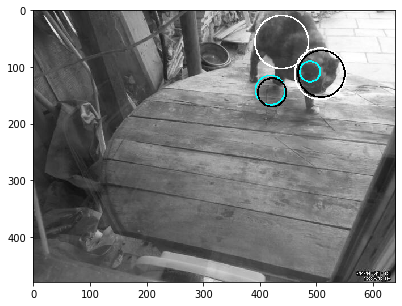

In [8]:
# The first three come with opencv, the rest I trained myself.
cascade_names = ['frontalcatface', 'frontalcatface_extended', 'eye', 'cat_arriving', 'cat_head_focus', 'cat_head_full']
cascades = {}
cascade_colours = {}
colourlist = [(0, 255, 0), (0, 0, 255), (255, 0, 0), (0, 255, 255), (255, 255, 255), (0, 0, 0)]
# colour to name: 
# frontalcatface green; frontalcatface_extended: blue; eye: red; cat_arriving: cyan; cat_head_focus: white; cat_head_full: black

for ci, cascade_name in enumerate(cascade_names):
    c = cv2.CascadeClassifier()
    # In OpenCV 4, you can call this line to get the preinstalled haar cascades.
    # In OpenCV 3, you need to figure out where the haar cascades are (or even download
    # them yourself from gihub).
    # if c.load(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_' + cascade_name + '.xml')):
    if c.load('./haar/haarcascade_' + cascade_name + '.xml'):
        cascades[cascade_name] = c
        cascade_colours[cascade_name] = colourlist[ci]
    else:
        print('failed to load cascade for %s' % cascade_name)
        
def find_cascades(cv_img):
    cv_cascade = cv2.cvtColor(cv_img, cv2.COLOR_GRAY2BGR)
    for name, cascade in cascades.items():
        # minNeighbours lets you control how 'strong' a match has to be to be considered.
        # at 20, only one match will be left (and it's right on the cat's face).
        # The cascades that come with OpenCV are not bad, but they do not work well for the low-quality
        # images that I get here.
        c = cascade.detectMultiScale(cv_img, minNeighbors=15)
        print('cascade %s detected %s' % (name, c))
        if len(c):
            colour = cascade_colours[name]
            for (x,y,w,h) in c:
                center = (x + w//2, y + h//2)
                frame = cv2.ellipse(cv_cascade, center, (w//2, h//2), 0, 0, 360, colour, 2)
    return cv_cascade
            
display_image(find_cascades(cv_gray))


### Addressing the lack of mice

One problem has turned out to be a lack of pictures of cats carrying mice. They just haven't been as successul hunting as last year. Maybe I shouldn't complain too much.

One way around this is to train a haar cascade (or a neural network) on images of cats with/without mice that I find on the internet, for example via Google ImageSearch or Flickr. However, most of the images found by Google require a license fee, and most of the ones on Flickr are private (download is blocked). I know it's quite common to scrape such images anyway and use them for training models (after all, nobody will be able to find out I used them this way), but it seems very rude.

So I can:
1. Contact individual people on Flickr to ask for permission to use their cat pictures
2. Wait for my cats to catch quite a few mice
3. Edit mice into cat pictures

I might still do 1. once I feel confident enough; 2. will happen by itself whatever I do; so I'll start with 3. I have neither the skills nor a license for Photoshop, so I went with gimp. I used two pictures of cat with mice that I found on wikimedia that were published under a [Creative Commons attribution license](https://creativecommons.org/licenses/by-sa/3.0/deed.en):

1.  https://commons.wikimedia.org/wiki/File:Cat_with_mouse.jpg
2.  https://commons.wikimedia.org/wiki/File:Cat_and_mouse.jpg

I cut the mice out of these pictures, adjusted the scale, transformed to grayscale, then pasted them into pictures of my cats. The result won't fool a human, but I just need it to be good enough to train a machine learning model to detect "there is something extra near this cat's mouth". I'm afraid I might train the model to detect my inept attempts at image editing though.

cascade frontalcatface detected ()
cascade frontalcatface_extended detected ()
cascade eye detected ()
cascade cat_arriving detected ()
cascade cat_head_focus detected ()
cascade cat_head_full detected ()
cascade frontalcatface detected ()
cascade frontalcatface_extended detected ()
cascade eye detected ()
cascade cat_arriving detected ()
cascade cat_head_focus detected [[246  27  49  49]]
cascade cat_head_full detected [[249  30  45  45]]


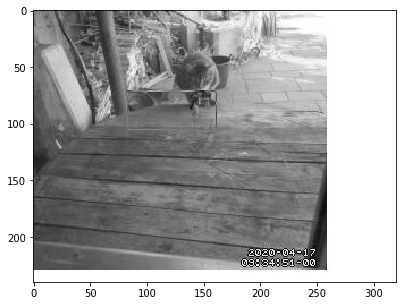

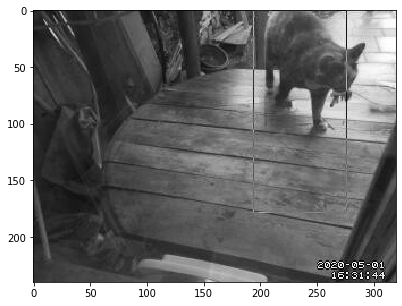

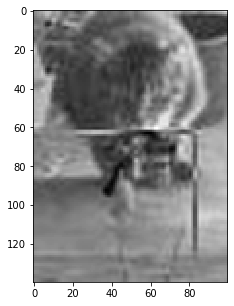

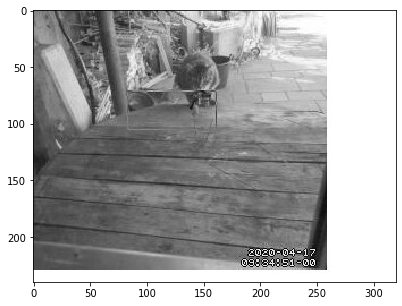

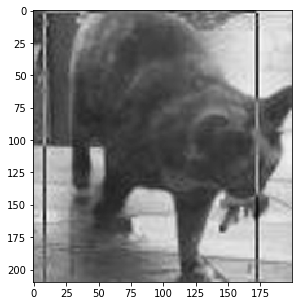

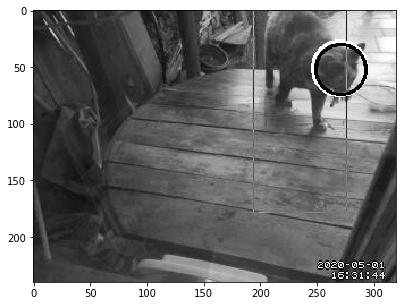

In [9]:
# Cat pictures with added mice
with_mouse_1 = Image.open('./catandmouse/cirmos-with-mouse.jpg')
with_mouse_2 = Image.open('./catandmouse/lala-with-mouse.jpg')

display_image(with_mouse_1, cmap=plt.cm.gray)
display_image(with_mouse_2, cmap=plt.cm.gray)

cv_mouse_1 = np.asarray(with_mouse_1)
cv_mouse_2 = np.asarray(with_mouse_2)
display_image(zoom(cutout(cv_mouse_1, 40, 110, 120, 170), factor=2.0), cmap=plt.cm.gray)
display_image(find_cascades(cv_mouse_1))
display_image(zoom(cutout(cv_mouse_2, 0, 105, 190, 290), factor=2.0), cmap=plt.cm.gray)
display_image(find_cascades(cv_mouse_2))

### Using tensorflow models

I do not have the capacity for training a tensorflow model from scratch. I'd need a lot of images (1000 might be enough), a significant amount of computing resources (it's hard to say how much without deciding first on model
architecture etc but a single VM instance on the Google Cloud (even without TPUs) where I can run training costs about 4-5 $/day. And of course I'd have to figure out how to construct the right kind of network (though I expect I could copy the architecture of models that do similar things).

Luckily, there's a whole collection of ready-made image recognition models available on [TensorFlow Hub](https://www.tensorflow.org/hub). I found it a little challenging to get them to run; some use different version
of the tensorflow libraries, and some require the input data to be presented in a specific format but don't
document how to convert common formats into that. Still, I got several models to run and tried them on my 
test data. However, they were often not able to identify the cat in my images, never mind the mouse. It seems like
a lot of the models on TensorFlow Hub are trained on high-quality images, and when I run them on the blurry
ones from my camera, they don't even consistently identify my cats as cats. 

I know my tortoiseshell cat is large (for a cat). One model identified her as a Staffordshire Bull Terrier. Not cool, tensorflow. Not cool.

So in order to use these models on my data, and to get them to figure out whether a cat carries a mouse, I'd have to do some pretty serious training of my own, and I just haven't done that. I think given the modest amount of training data I have, and seeing how I don't really know much about how to create my own tensorflow model, I'd rather see how far I can get with just Haar cascades. But I'll include my attempts at using Tensorflow below, for your edification and enjoyment.

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from skimage import data, transform

In [12]:
# From the TF object detection tutorial: utilities for drawing boxes
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               thickness=1,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)],
              width=thickness,
              fill=color)

    for display_str in display_str_list[::-1]:
        print('box at %d %d represents %s' % (left, top, display_str))
    
def draw_boxes(image, boxes, class_names, scores, max_boxes=5, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color,
                                       display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Found 100 objects.
box at 374 6 represents Cat: 37%
box at 369 2 represents Dog: 35%
box at 490 162 represents Footwear: 13%
box at 476 173 represents Footwear: 10%
box at 445 177 represents Footwear: 10%
Found 100 objects.
box at 199 5 represents Dog: 50%
box at 201 2 represents Cat: 21%
box at 241 96 represents Footwear: 18%
box at 246 96 represents Footwear: 17%
box at 243 90 represents Footwear: 13%
Found 100 objects.
box at 0 83 represents Stairs: 25%
box at 93 41 represents Clothing: 12%
box at 16 52 represents Stairs: 11%
box at 62 85 represents Footwear: 11%
box at 8 73 represents Stairs: 11%
Found 100 objects.
box at 0 40 represents Cat: 42%
box at 76 40 represents Dog: 23%
box at 2 0 represents Tree: 13%
box at 636 424 represents Tree: 12%
box at 576 424 represents Tree: 10%
Found 100 objects.
box at 0 20 represents Cat: 80%
box at 1 506 represents Plant: 16%
box at 18 556 represents Plant: 15%
box at 10 536 represents Plant: 14%
box at 0 543 represents Plant: 12%


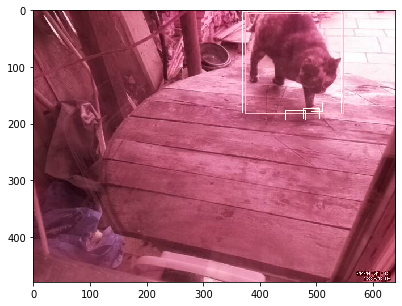

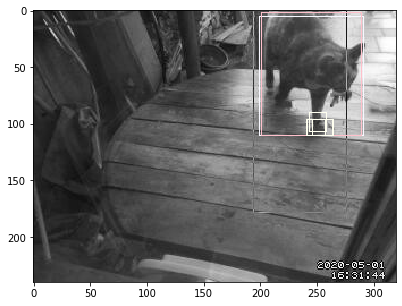

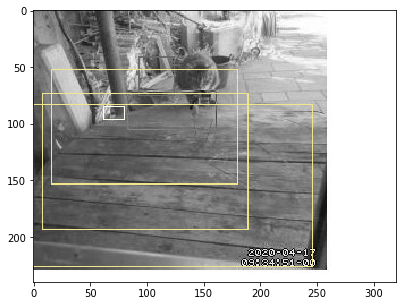

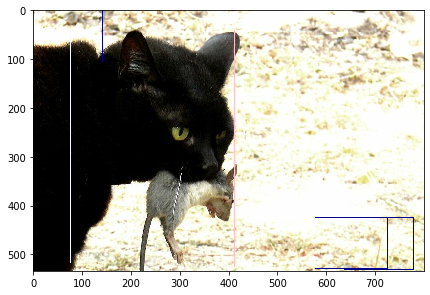

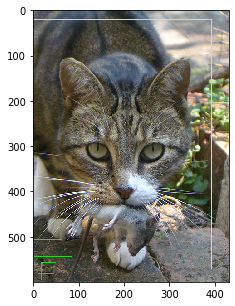

In [130]:
# Apply object detector (from tutorial)

# This module is too large for my laptop
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" 

# This module works with the tutorial code, but it mis-parses the images from the pi.
ssd_module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

detector = hub.load(ssd_module_handle).signatures['default']

def load_image(path):
    i = tf.io.read_file(path)
    i = tf.image.decode_jpeg(i, channels=3)
    return i

def run_detector(detector, path):
    i = load_image(path)
    converted = tf.image.convert_image_dtype(i, tf.float32)[tf.newaxis, ...]
    result = detector(converted)
    result = {key:value.numpy() for key,value in result.items()}
    print("Found %d objects." % len(result["detection_scores"]))
    image_with_boxes = draw_boxes(
      i.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

    display_image(image_with_boxes)
    return result
    
res = run_detector(detector, name)
res = run_detector(detector, './lala-with-mouse.jpg')
res = run_detector(detector, './cirmos-with-mouse.jpg')
res = run_detector(detector, './fromtheinternet/Cat_with_mouse.jpg')
res = run_detector(detector, './fromtheinternet/432px-Cat_and_mouse.jpg')
